Epoch 0, Loss: 1.229598
Epoch 1000, Loss: 0.007803
Epoch 2000, Loss: 0.003377
Epoch 3000, Loss: 0.002923
Epoch 4000, Loss: 0.002750
Epoch 5000, Loss: 0.002635
Epoch 6000, Loss: 0.002542
Epoch 7000, Loss: 0.002459
Epoch 8000, Loss: 0.002236
Epoch 9000, Loss: 0.000909


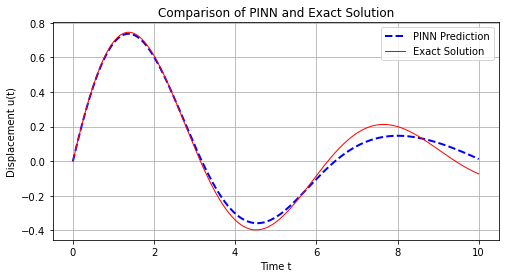

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution
def exact_solution(x):
    return np.exp(-x/5) * np.sin(x)

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),    # Input layer: 1D x → 20D
            nn.Tanh(),           # Activation function
            nn.Linear(20, 20),   # Hidden layer: 20 → 20
            nn.Tanh(),
            nn.Linear(20, 20),   # Hidden layer: 20 → 20
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer: 20 → 1D y
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate training data
x_residual = torch.linspace(0, 10, 1000, requires_grad=True).view(-1, 1)  # Residual points
x_initial = torch.tensor([[0.0]], requires_grad=True)                    # Initial condition point

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute PDE residual
    y_pred = model(x_residual)
    dy_dx = torch.autograd.grad(y_pred, x_residual, 
                               grad_outputs=torch.ones_like(y_pred),
                               create_graph=True)[0]  # First derivative
    d2y_dx2 = torch.autograd.grad(dy_dx, x_residual,
                                 grad_outputs=torch.ones_like(dy_dx),
                                 create_graph=True)[0]  # Second derivative
    
    # Residual equation: y'' + (1/5)y' + y + (1/5)e^(-x/5)cos(x) = 0
    residual = d2y_dx2 + (1/5)*dy_dx + y_pred + (1/5)*torch.exp(-x_residual/5)*torch.cos(x_residual)
    loss_equation = torch.mean(residual**2)  # Mean squared error of PDE residual
    
    # Initial condition y(0)=0 loss
    y_initial = model(x_initial)
    loss_y0 = torch.mean((y_initial - 0)**2)
    
    # Initial condition y'(0)=1 loss
    dy_dx_initial = torch.autograd.grad(y_initial, x_initial,
                                      grad_outputs=torch.ones_like(y_initial),
                                      create_graph=True)[0]
    loss_y_prime0 = torch.mean((dy_dx_initial - 1)**2)
    
    # Total loss
    total_loss = loss_equation + loss_y0 + loss_y_prime0
    
    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

# Plot results
x_test = np.linspace(0, 10, 1000).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_pred = model(x_test_tensor).detach().numpy()
y_exact = exact_solution(x_test)

# Plot results
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9829111329010637, mae_pinn: 0.031241539868240742, rmse_pinn: 0.040696484541137265, inf_norm_pinn: 0.08616273143175449


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_10.csv', index=False)
print(" pinn_10.csv")

数据已保存至 pinn_10.csv
